In [1]:
import numpy as np
# import cv2
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import pandas as pd
# import tqdm

from tqdm import tqdm

from scipy.fftpack import fft,ifft
# import PIL
# import matlab
# import matlab.engine
import math

#engine = matlab.engine.start_matlab() # Start MATLAB process

In [2]:
imgData = np.fromfile('whole_bone.raw', dtype="float32")
#imgData = imgData.reshape(width, height, channels)
df=pd.read_excel('angle_r.xlsx')
# df.values返回多位数组
angle_r = df.values
a_r = np.zeros((2,60))
a_r[0] = angle_r[[0,2,4,6],:].reshape(1,60)
a_r[1] = angle_r[[1,3,5,7],:].reshape(1,60)
np.max(a_r[1])
pi_d = 4.0625#mm
fir = np.zeros((60,128))
base = 128*128


pro = imgData.reshape(60,128,128)
end = 128*128
im1 = imgData[0:end]
p1 = pro[:,70,:]
#plt.imshow(p1,cmap="gray")
fft_p = np.zeros((60,128))
#engine.imshow(engine.iradon(matlab.double(list_p),0:59),[])

In [3]:
def get_spect_tran_m(theta):
    #rotate detector theta from initial ang
    c = np.zeros((end,128),dtype="float32")
    for i in np.linspace(-63.5,63.5,128):
        ang = math.pi-theta*math.pi/180
        a = math.tan(ang)
        b = i/math.cos(theta*math.pi/180+1e-6)
        c_y = int(i+63.5)
        if a<=0:
            for x in range(-63,65):
                for y in range(-63,65):
                    x2 = x-1
                    y2 = y-1

                    if (a*x+b-y)*(a*x2+b-y2) <=0:
                        pos = (x+63)*128+y+63
                        c[pos,c_y] = 1
        else:
            for x in range(-63,65):
                for y in range(-63,65):
                    x1 = x-1
                    y1 = y
                    x2 = x
                    y2 = y-2
                    if (a*x1+b-y1)*(a*x2+b-y2) <=0:
                        pos = (x+63)*128+y+63
                        c[pos,c_y] = 1

    return c

In [4]:
theta_range = np.arange(0,60,dtype="float32")*6
bias = 1e-6
theta_range[np.linspace(0,45,4,dtype = "int")] = theta_range[np.linspace(0,45,4,dtype="int")] + bias
dic_c = {}
i = 0

for n in tqdm(range(0,60)):
    num = str(i)
    dic_c[num] = get_spect_tran_m(theta_range[i])
    i = i + 1

100%|██████████| 60/60 [02:39<00:00,  2.65s/it]


0%|          | 0/100 [00:00<?, ?it/s](16384, 7680)
[1.00e-06 6.00e+00 1.20e+01 1.80e+01 2.40e+01 3.00e+01 3.60e+01 4.20e+01
 4.80e+01 5.40e+01 6.00e+01 6.60e+01 7.20e+01 7.80e+01 8.40e+01 9.00e+01
 9.60e+01 1.02e+02 1.08e+02 1.14e+02 1.20e+02 1.26e+02 1.32e+02 1.38e+02
 1.44e+02 1.50e+02 1.56e+02 1.62e+02 1.68e+02 1.74e+02 1.80e+02 1.86e+02
 1.92e+02 1.98e+02 2.04e+02 2.10e+02 2.16e+02 2.22e+02 2.28e+02 2.34e+02
 2.40e+02 2.46e+02 2.52e+02 2.58e+02 2.64e+02 2.70e+02 2.76e+02 2.82e+02
 2.88e+02 2.94e+02 3.00e+02 3.06e+02 3.12e+02 3.18e+02 3.24e+02 3.30e+02
 3.36e+02 3.42e+02 3.48e+02 3.54e+02]
0.0
True
100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


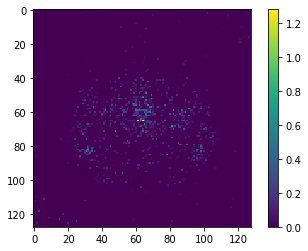

In [5]:

total_c = np.zeros((128*128,128*60),dtype="float32")
total_p = np.zeros((1,128*60),dtype="float32").squeeze(0)
for i in range(0,59):
    range1 = 128*i
    range2 = 128*(i+1) 
    total_c[:,range1:range2] = dic_c[str(i)]
    total_p[range1:range2] = p1[i]

print(total_c.shape)

print(theta_range)

m = dic_c["1"]
print(m[8257,64])
mm = theta_range[1]
print(mm==6)

iter = 100
f0 = np.ones((1,end),dtype="float32").squeeze(0)
temp = np.ones((1,end),dtype="float32").squeeze(0)

for i in tqdm(range(0,iter)):
    temp= total_c.dot(total_p/(f0.dot(total_c+bias)))*(f0/np.sum(total_c+bias,axis=1))
    f0 = temp
plt.imshow(f0.reshape(128,128))
plt.colorbar()

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


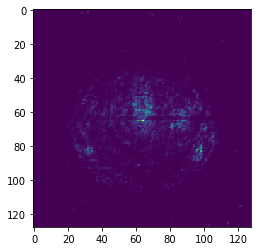

In [6]:
f0 = np.ones((1,end),dtype="float32").squeeze(0)
temp = np.ones((1,end),dtype="float32").squeeze(0)
a1 = 0
a2 = 128*15
a3 = 128*30
a4 = 128*45
a5 = 128*60
iter = 4
for i in tqdm(range(0,iter)):
    temp= total_c[:,a1:a2].dot(total_p[a1:a2]/(f0.dot(total_c[:,a1:a2]+bias)))*(f0/np.sum(total_c[:,a1:a2]+bias,axis=1))
    f0 = temp
    temp= total_c[:,a2:a3].dot(total_p[a2:a3]/(f0.dot(total_c[:,a2:a3]+bias)))*(f0/np.sum(total_c[:,a2:a3]+bias,axis=1))
    f0 = temp
    temp= total_c[:,a3:a4].dot(total_p[a3:a4]/(f0.dot(total_c[:,a3:a4]+bias)))*(f0/np.sum(total_c[:,a3:a4]+bias,axis=1))
    f0 = temp
    temp= total_c[:,a4:a5].dot(total_p[a4:a5]/(f0.dot(total_c[:,a4:a5]+bias)))*(f0/np.sum(total_c[:,a4:a5]+bias,axis=1))
    f0 = temp
plt.imshow(f0.reshape(128,128))

plt.show()

In [7]:
osem_spect = np.zeros((128,128,128),dtype="float32")
def OSEM_SPECT(i,idata):
    pro_splice = pro[:,i,:]
    total_p = pro_splice.reshape(1,128*60).squeeze(0)
    f0 = np.ones((1,end),dtype="float32").squeeze(0)
    temp = np.ones((1,end),dtype="float32").squeeze(0)
    for i in range(0,iter):
        temp= total_c[:,a1:a2].dot(total_p[a1:a2]/(f0.dot(total_c[:,a1:a2]+bias)))*(f0/np.sum(total_c[:,a1:a2]+bias,axis=1))
        f0 = temp
        temp= total_c[:,a2:a3].dot(total_p[a2:a3]/(f0.dot(total_c[:,a2:a3]+bias)))*(f0/np.sum(total_c[:,a2:a3]+bias,axis=1))
        f0 = temp
        temp= total_c[:,a3:a4].dot(total_p[a3:a4]/(f0.dot(total_c[:,a3:a4]+bias)))*(f0/np.sum(total_c[:,a3:a4]+bias,axis=1))
        f0 = temp
        temp= total_c[:,a4:a5].dot(total_p[a4:a5]/(f0.dot(total_c[:,a4:a5]+bias)))*(f0/np.sum(total_c[:,a4:a5]+bias,axis=1))
        f0 = temp
    return f0.reshape(128,128)
for i in tqdm(range(0,128)):
    osem_spect[i] = OSEM_SPECT(i,4)

100%|██████████| 128/128 [07:24<00:00,  3.47s/it]


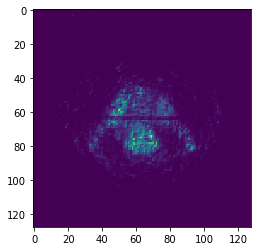

In [17]:
plt.imshow(osem_spect[1,:,:])
osem_spect.tofile("osem_mine.raw")

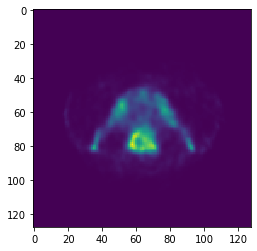

In [9]:
osemData = np.fromfile('OSEM_recon.raw', dtype="float32")
osem = osemData.reshape(128,128,128)
plt.imshow(osem[126,:,:])